## Quora Insincere Questions Classification
#### Aleix Casellas Comas, Rubén Barco Terrones, Andreu Masdeu Ninot, Pablo Lázaro Terrones, Marco Gani Remane

### Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import keras, nltk, os, matplotlib
import pandas as pd
import numpy as np
import seaborn as sns

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from stop_words import get_stop_words
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')

C:\Users\andre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### ETL
#### Split data into train and test

In [8]:
dir_data = 'C:/Users/andre/Documents/Master/NLP assigments/'
train_data = pd.read_csv(dir_data+'train.csv')
train_data.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [9]:
X_train, X_test = train_test_split(train_data, test_size=0.2, stratify=train_data['target'], random_state=123)

In [10]:
X_train.shape, X_test.shape

((1044897, 3), (261225, 3))

In [11]:
y_train =  X_train['target'].values
y_train.shape

(1044897,)

In [12]:
y_test = X_test['target'].values
y_test.shape

(261225,)

In [13]:
X_train = X_train['question_text'].values
X_test = X_test['question_text'].values

## Tokenize data

In [14]:
stop_words = get_stop_words('english')
punctuation = ['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}','?',"''"]

## Keep appending stop words it they are detected
# I'll: we remove 'll, it's: remove 's, can't: remove 't
stop_words.extend(['\'ll', '\'s', '\'t', '``','n\'t'])

lem = WordNetLemmatizer()
snow  = SnowballStemmer(language='english')

In [15]:
lem.lemmatize('swimming')

'swimming'

In [16]:
snow.stem('swimming')

'swim'

In [17]:
def filtering(v):
    tokens = word_tokenize(v)

    filtered = [word.lower() for word in tokens if word.lower() not in stop_words and word not in punctuation and len(word) < 25]
    v2 = filtered
    v3 = []
    for elem in v2:
        #v3.append(elem)
        v3.append(snow.stem(elem)) # To use if you wished to apply stemming
    str1 = ' '.join(v3)
    return str1

In [18]:
train = []
for i in range(0,len(X_train)):
    train.append(filtering(X_train[i]))

In [19]:
test = []
for i in range(0,len(X_test)):
    test.append(filtering(X_test[i]))

In [20]:
n_words = 20000
tokenizer = text.Tokenizer(num_words = n_words, filters='"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train+test)

In [21]:
traintok = tokenizer.texts_to_sequences(train)
testtok = tokenizer.texts_to_sequences(test)

In [22]:
maxlen = 0
lengths = []
for x in traintok:
    length = len(x)
    lengths.append(length)
    if length > maxlen:
        maxlen = length

print(maxlen)

179


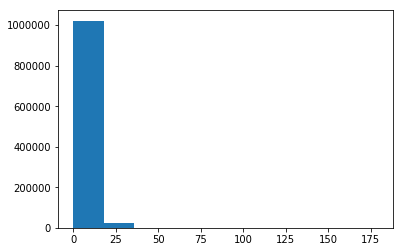

In [23]:
plt.hist(lengths, bins = 10)

plt.show()

In [24]:
maxlen = 25

X_t = sequence.pad_sequences(traintok, maxlen=maxlen)
X_te = sequence.pad_sequences(testtok, maxlen=maxlen)

In [25]:
def text_model(nhid = 2, drop = 0.1 , recdrop = 0.1, units = 50, drop2 = 0):
    model = Sequential()
    leaky = keras.layers.LeakyReLU(alpha=0.05)
    model.add(Embedding( n_words , 128, input_length=maxlen, trainable = True))
    
    model.add(Bidirectional(LSTM(units, return_sequences=True, dropout=drop, recurrent_dropout=recdrop)))
    model.add(GlobalMaxPool1D())
    
    for i in range(0,nhid):
        model.add(Dense(int(128/(2 ** i))))
        model.add(leaky)
        model.add(BatchNormalization())
        model.add(Dropout (drop2))

    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    return model

In [33]:
model = text_model(units = 50, nhid = 1, drop = 0.1, recdrop = 0.1, drop2 = 0.1 )

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 128)           2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 100)           71600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [35]:
history = model.fit(X_t, y_train, batch_size = 32, epochs = 2, callbacks = [], 
                    validation_data = (X_te, y_test), verbose = 1)

Train on 1044897 samples, validate on 261225 samples
Epoch 1/2
1044897/1044897 [==============================] - 2514s 2ms/step - loss: 0.1278 - acc: 0.9500 - val_loss: 0.1261 - val_acc: 0.9492
Epoch 2/2
1044897/1044897 [==============================] - 3251s 3ms/step - loss: 0.1133 - acc: 0.9556 - val_loss: 0.1138 - val_acc: 0.9553


In [36]:
model.save("lstm_2.h5")

In [30]:
model = keras.models.load_model("lstm_2.h5")

### Metrics

In [31]:
confusion_matrix(np.round(model.predict(X_te).reshape(-1)).astype(int), y_test)

array([[241733,   8357],
       [  3330,   7805]], dtype=int64)

In [32]:
f1_score(np.round(model.predict(X_te).reshape(-1)).astype(int), y_test)

0.571857713301828

In [33]:
f1_score(np.round(model.predict(X_t).reshape(-1)).astype(int), y_train)

0.6235073198300851

# Test submission

In [21]:
dir_data = 'C:/Users/andre/Documents/Master/NLP assigments/'
test_data = pd.read_csv(dir_data+'test.csv')
test_data.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [23]:
X_kaggle = test_data['question_text'].values

In [24]:
test_kaggle = []
for i in range(0,len(X_kaggle)):
    test_kaggle.append(filtering(X_kaggle[i]))

In [25]:
testkaggletok = tokenizer.texts_to_sequences(test_kaggle)

In [26]:
X_kg = sequence.pad_sequences(testkaggletok, maxlen=maxlen)

In [27]:
preds = model.predict(X_kg)

In [33]:
preds = preds.reshape(-1)

In [42]:
pred = np.round(preds).astype(int)

In [48]:
submission = pd.DataFrame()
submission['qid'] = test_data['qid']
submission['prediction'] = pred

In [50]:
submission.to_csv('submission.csv', index=False)